# TWAP交易模拟与分析

本notebook实现TWAP (Time-Weighted Average Price) 交易策略的模拟和分析。

## 交易规则

1. **目标**：在10分钟区间内完成目标交易量（区间总成交量的1%）
2. **时间切片**：每3秒执行一次下单
3. **流动性限制**：
   - 买入：受 `ask1_v`（卖一量）限制
   - 卖出：受 `bid1_v`（买一量）限制
4. **未完成订单处理**：
   - 如果某个3秒时刻无法完成计划下单量（流动性不足），则延后
   - 在最后一个时刻强制完成所有剩余订单
   - 最后时刻的强制成交有额外成本 `c`（滑点）

## 关键指标

- **成交均价**：实际成交的加权平均价格
- **TWAP基准价**：时间加权平均价格（mid_price的平均）
- **滑点**：成交均价与TWAP基准价的差异
- **完成率**：按计划完成的订单比例
- **紧急成交量**：最后时刻强制成交的量
- **额外成本**：紧急成交产生的额外费用


## 1. 导入库和加载数据


In [2]:
# 导入twap_simulator模块
import sys
sys.path.append('.')

from twap_simulator import TWAPSimulator
import pandas as pd
import numpy as np

# 读取数据
df = pd.read_parquet('orderbook_sampled_10min_intervals.parquet')
interval_stats = pd.read_parquet('interval_statistics.parquet')

print(f"✓ 数据加载完成")
print(f"  - 订单薄snapshot: {len(df)} 条")
print(f"  - 区间数: {len(interval_stats)}")
print(f"\n数据预览:")
df[['timestamp', 'interval_id', 'bid1_p', 'ask1_p', 'bid1_v', 'ask1_v', 'mid_price']].head()


✓ 数据加载完成
  - 订单薄snapshot: 4000 条
  - 区间数: 20

数据预览:


,timestamp,interval_id,bid1_p,ask1_p,bid1_v,ask1_v,mid_price
0,2025-12-20 10:00:00,1,104.92,104.94,1852,7046,104.930
1,2025-12-20 10:00:03,1,104.80,104.83,7035,423,104.815
2,2025-12-20 10:00:06,1,104.77,104.78,5653,2846,104.775
3,2025-12-20 10:00:09,1,104.95,104.97,7449,9044,104.960
4,2025-12-20 10:00:12,1,104.73,104.75,1025,9243,104.740


## 2. 运行TWAP模拟


In [3]:
# 创建模拟器
simulator = TWAPSimulator(direction='buy', emergency_cost_bps=5.0)

# 运行模拟
print("开始TWAP交易模拟...")
results = simulator.simulate_all_intervals(df, interval_stats)

print(f"✓ 模拟完成！共 {len(results)} 个区间")

# 整理结果
results_summary = pd.DataFrame([{
    'interval_id': r['interval_id'],
    'session': r['session'],
    'target_volume': r['target_volume'],
    'executed_volume': r['executed_volume'],
    'completion_rate': r['completion_rate'],
    'avg_execution_price': r['avg_execution_price'],
    'twap_benchmark': r['twap_benchmark'],
    'vwap_benchmark': r['vwap_benchmark'],
    'slippage_vs_twap_bps': r['slippage_vs_twap_bps'],
    'slippage_vs_vwap_bps': r['slippage_vs_vwap_bps'],
    'n_trades': r['n_trades'],
    'emergency_volume_pct': r['emergency_volume_pct']
} for r in results])

print("\n模拟结果汇总:")
results_summary


开始TWAP交易模拟...
✓ 模拟完成！共 20 个区间

模拟结果汇总:


,interval_id,session,target_volume,executed_volume,completion_rate,avg_execution_price,twap_benchmark,vwap_benchmark,slippage_vs_twap_bps,slippage_vs_vwap_bps,n_trades,emergency_volume_pct
0,1,上午,11999.94,11999,0.999922,104.247433,104.252200,104.760328,-0.457245,-48.958848,200,0.0
1,2,上午,15000.07,15000,0.999995,102.124950,102.115900,103.150916,0.886248,-99.462635,200,0.0
2,3,上午,17999.88,17999,0.999951,99.223064,99.229650,100.467223,-0.663707,-123.837269,200,0.0
3,4,上午,20999.84,20999,0.999960,96.618999,96.618325,97.515370,0.069759,-91.921030,200,0.0
4,5,上午,23999.99,23999,0.999959,95.193163,95.187425,95.530894,0.602860,-35.353060,200,0.0
5,6,上午,27000.01,27000,1.000000,95.440556,95.430725,95.061227,1.030164,39.903630,200,0.0
6,7,上午,29999.98,29999,0.999967,97.292027,97.272075,96.284756,2.051161,104.613762,200,0.0
7,8,上午,33000.06,33000,0.999998,100.083488,100.073325,98.793080,1.015543,130.617282,200,0.0
8,9,上午,35999.98,35999,0.999973,102.863748,102.846625,101.694757,1.664868,114.950884,200,0.0
9,10,下午,65999.91,65999,0.999986,101.633197,101.606300,100.230529,2.647135,139.944170,200,0.0


## 3. 统计分析：TWAP vs VWAP


In [4]:
print("="*80)
print("TWAP交易模拟 - 统计分析")
print("="*80)

print("\n1. 基本信息:")
print(f"   - 模拟区间数: {len(results_summary)}")
print(f"   - 平均完成率: {results_summary['completion_rate'].mean()*100:.2f}%")
print(f"   - 总目标交易量: {results_summary['target_volume'].sum():,.0f} 股")

print("\n2. 滑点分析 (相对于TWAP):")
print(f"   - 平均滑点: {results_summary['slippage_vs_twap_bps'].mean():.2f} bp")
print(f"   - 滑点标准差: {results_summary['slippage_vs_twap_bps'].std():.2f} bp")
print(f"   - 最小滑点: {results_summary['slippage_vs_twap_bps'].min():.2f} bp")
print(f"   - 最大滑点: {results_summary['slippage_vs_twap_bps'].max():.2f} bp")

print("\n3. 滑点分析 (相对于VWAP):")
print(f"   - 平均滑点: {results_summary['slippage_vs_vwap_bps'].mean():.2f} bp")
print(f"   - 滑点标准差: {results_summary['slippage_vs_vwap_bps'].std():.2f} bp")
print(f"   - 最小滑点: {results_summary['slippage_vs_vwap_bps'].min():.2f} bp")
print(f"   - 最大滑点: {results_summary['slippage_vs_vwap_bps'].max():.2f} bp")

print("\n4. TWAP vs VWAP 基准对比:")
print(f"   - TWAP基准均价: {results_summary['twap_benchmark'].mean():.4f}")
print(f"   - VWAP基准均价: {results_summary['vwap_benchmark'].mean():.4f}")
price_diff_bps = ((results_summary['vwap_benchmark'].mean() - results_summary['twap_benchmark'].mean()) / 
                   results_summary['twap_benchmark'].mean()) * 10000
print(f"   - VWAP与TWAP差异: {price_diff_bps:.2f} bp")

print("\n5. 基准选择建议:")
abs_slippage_twap = results_summary['slippage_vs_twap_bps'].abs().mean()
abs_slippage_vwap = results_summary['slippage_vs_vwap_bps'].abs().mean()
print(f"   - 相对TWAP的平均绝对滑点: {abs_slippage_twap:.2f} bp")
print(f"   - 相对VWAP的平均绝对滑点: {abs_slippage_vwap:.2f} bp")
if abs_slippage_vwap < abs_slippage_twap:
    print(f"   ✓ VWAP更接近实际成交价，建议作为业绩基准")
else:
    print(f"   ✓ TWAP更接近实际成交价，建议作为业绩基准")

print("\n6. 紧急成交分析:")
total_emergency_pct = (results_summary['emergency_volume_pct'] * results_summary['target_volume']).sum() / results_summary['target_volume'].sum()
print(f"   - 平均紧急成交比例: {total_emergency_pct:.2f}%")
print(f"   - 有紧急成交的区间: {(results_summary['emergency_volume_pct'] > 0).sum()} 个")

print("\n" + "="*80)


TWAP交易模拟 - 统计分析

1. 基本信息:
   - 模拟区间数: 20
   - 平均完成率: 100.00%
   - 总目标交易量: 1,106,999 股

2. 滑点分析 (相对于TWAP):
   - 平均滑点: 0.90 bp
   - 滑点标准差: 1.62 bp
   - 最小滑点: -1.69 bp
   - 最大滑点: 5.05 bp

3. 滑点分析 (相对于VWAP):
   - 平均滑点: 3.21 bp
   - 滑点标准差: 103.46 bp
   - 最小滑点: -157.03 bp
   - 最大滑点: 140.64 bp

4. TWAP vs VWAP 基准对比:
   - TWAP基准均价: 99.6754
   - VWAP基准均价: 99.6601
   - VWAP与TWAP差异: -1.53 bp

5. 基准选择建议:
   - 相对TWAP的平均绝对滑点: 1.41 bp
   - 相对VWAP的平均绝对滑点: 92.47 bp
   ✓ TWAP更接近实际成交价，建议作为业绩基准

6. 紧急成交分析:
   - 平均紧急成交比例: 0.00%
   - 有紧急成交的区间: 0 个



## 4. 可视化对比图表

使用文本表格展示TWAP vs VWAP对比（如果matplotlib可用，可以绘制图表）


In [8]:
# 保存结果
results_summary.to_csv('twap_simulation_summary.csv', index=False, encoding='utf-8-sig')
print("✓ 结果已保存到 twap_simulation_summary.csv")

# 显示对比表格
print("\n各区间TWAP vs VWAP滑点对比:")
print("="*100)
comparison_df = results_summary[['interval_id', 'session', 'avg_execution_price', 
                                  'twap_benchmark', 'vwap_benchmark', 
                                  'slippage_vs_twap_bps', 'slippage_vs_vwap_bps']].copy()
comparison_df['better_benchmark'] = comparison_df.apply(
    lambda row: 'VWAP' if abs(row['slippage_vs_vwap_bps']) < abs(row['slippage_vs_twap_bps']) else 'TWAP',
    axis=1
)
print(comparison_df)

print("\n汇总统计:")
print(f"VWAP更优的区间数: {(comparison_df['better_benchmark'] == 'VWAP').sum()}")
print(f"TWAP更优的区间数: {(comparison_df['better_benchmark'] == 'TWAP').sum()}")


✓ 结果已保存到 twap_simulation_summary.csv

各区间TWAP vs VWAP滑点对比:
    interval_id session  avg_execution_price  twap_benchmark  vwap_benchmark  \
0             1      上午           104.261050      104.252200      104.760328   
1             2      上午           102.124950      102.115900      103.150916   
2             3      上午            99.238750       99.229650      100.467223   
3             4      上午            96.627600       96.618325       97.515370   
4             5      上午            95.196200       95.187425       95.530894   
5             6      上午            95.440556       95.430725       95.061227   
6             7      上午            97.282357       97.272075       96.284756   
7             8      上午           100.083488      100.073325       98.793080   
8             9      上午           102.857644      102.846625      101.694757   
9            10      下午           101.629103      101.606300      100.230529   
10           11      下午           103.969319      103.947225 

## 5. 绘图可视化


In [10]:
try:
    import matplotlib.pyplot as plt
    import matplotlib
    
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['Microsoft YahHei', 'SimHei', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False
    
    MATPLOTLIB_OK = True
    print(f"✓ Matplotlib可用 (版本: {matplotlib.__version__})")
except Exception as e:
    MATPLOTLIB_OK = False
    print(f"✗ Matplotlib不可用: {e}")


✓ Matplotlib可用 (版本: 3.10.8)


### 5.1 滑点对比：TWAP vs VWAP


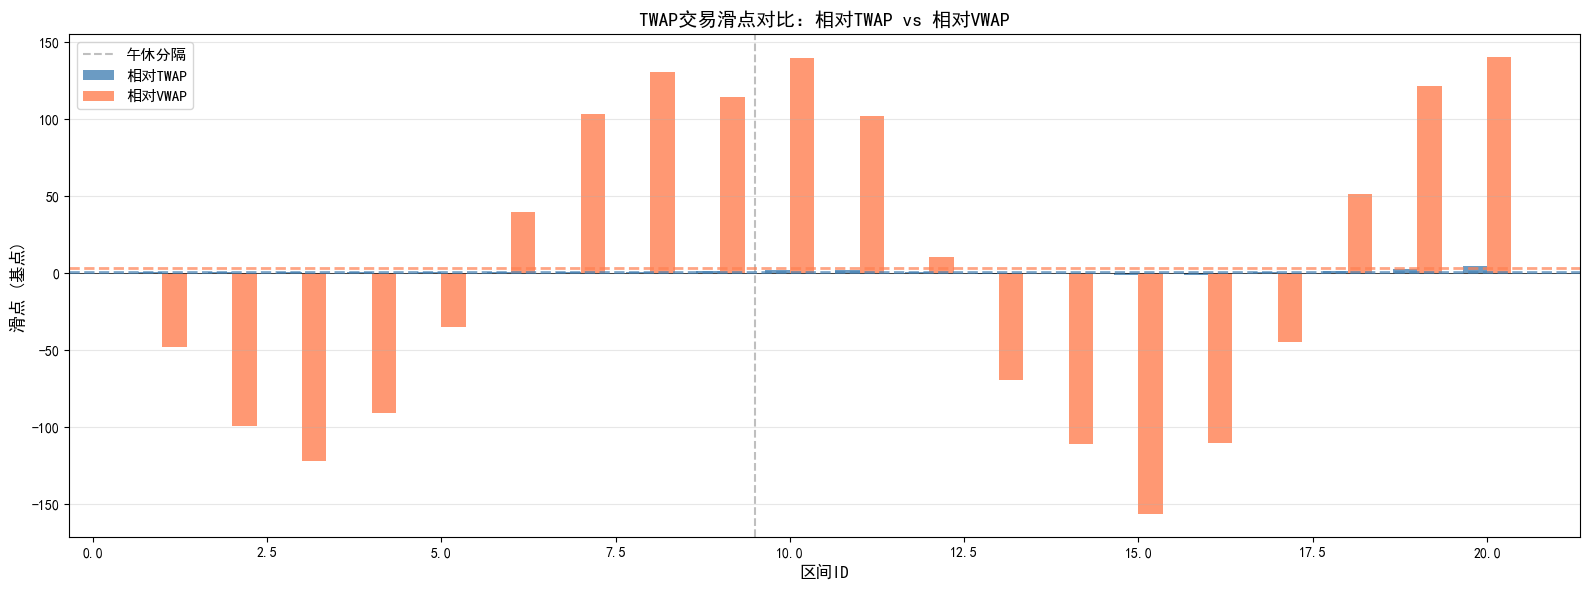

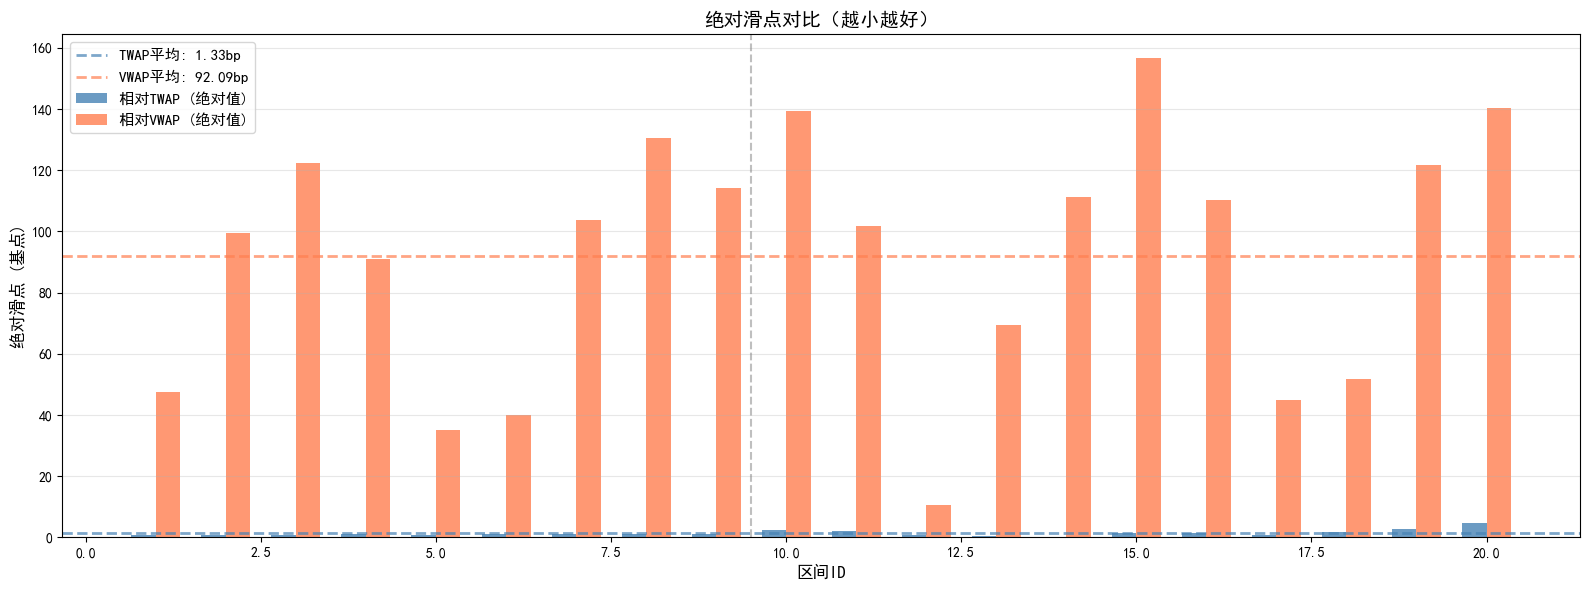

✓ 图表已保存: twap_vs_vwap_slippage_1.png
✓ 图表已保存: twap_vs_vwap_slippage_2.png


In [11]:
if MATPLOTLIB_OK:
    x = results_summary['interval_id']
    width = 0.35
    
    # 图1: 滑点对比 - 柱状图
    plt.figure(figsize=(16, 6))
    plt.bar(x - width/2, results_summary['slippage_vs_twap_bps'], 
            width, label='相对TWAP', alpha=0.8, color='steelblue')
    plt.bar(x + width/2, results_summary['slippage_vs_vwap_bps'], 
            width, label='相对VWAP', alpha=0.8, color='coral')
    
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, label='午休分隔')
    plt.axhline(y=results_summary['slippage_vs_twap_bps'].mean(), 
                color='steelblue', linestyle='--', linewidth=2, alpha=0.7)
    plt.axhline(y=results_summary['slippage_vs_vwap_bps'].mean(), 
                color='coral', linestyle='--', linewidth=2, alpha=0.7)
    
    plt.xlabel('区间ID', fontsize=12, fontweight='bold')
    plt.ylabel('滑点 (基点)', fontsize=12, fontweight='bold')
    plt.title('TWAP交易滑点对比：相对TWAP vs 相对VWAP', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='best')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('twap_vs_vwap_slippage_1.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 图2: 绝对滑点对比
    plt.figure(figsize=(16, 6))
    abs_twap = results_summary['slippage_vs_twap_bps'].abs()
    abs_vwap = results_summary['slippage_vs_vwap_bps'].abs()
    
    plt.bar(x - width/2, abs_twap, width, label='相对TWAP (绝对值)', alpha=0.8, color='steelblue')
    plt.bar(x + width/2, abs_vwap, width, label='相对VWAP (绝对值)', alpha=0.8, color='coral')
    
    plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    plt.axhline(y=abs_twap.mean(), color='steelblue', linestyle='--', 
                linewidth=2, alpha=0.7, label=f'TWAP平均: {abs_twap.mean():.2f}bp')
    plt.axhline(y=abs_vwap.mean(), color='coral', linestyle='--', 
                linewidth=2, alpha=0.7, label=f'VWAP平均: {abs_vwap.mean():.2f}bp')
    
    plt.xlabel('区间ID', fontsize=12, fontweight='bold')
    plt.ylabel('绝对滑点 (基点)', fontsize=12, fontweight='bold')
    plt.title('绝对滑点对比（越小越好）', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='best')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('twap_vs_vwap_slippage_2.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 图表已保存: twap_vs_vwap_slippage_1.png")
    print("✓ 图表已保存: twap_vs_vwap_slippage_2.png")
else:
    print("跳过绘图（Matplotlib不可用）")


### 5.2 价格对比：实际成交价 vs TWAP vs VWAP


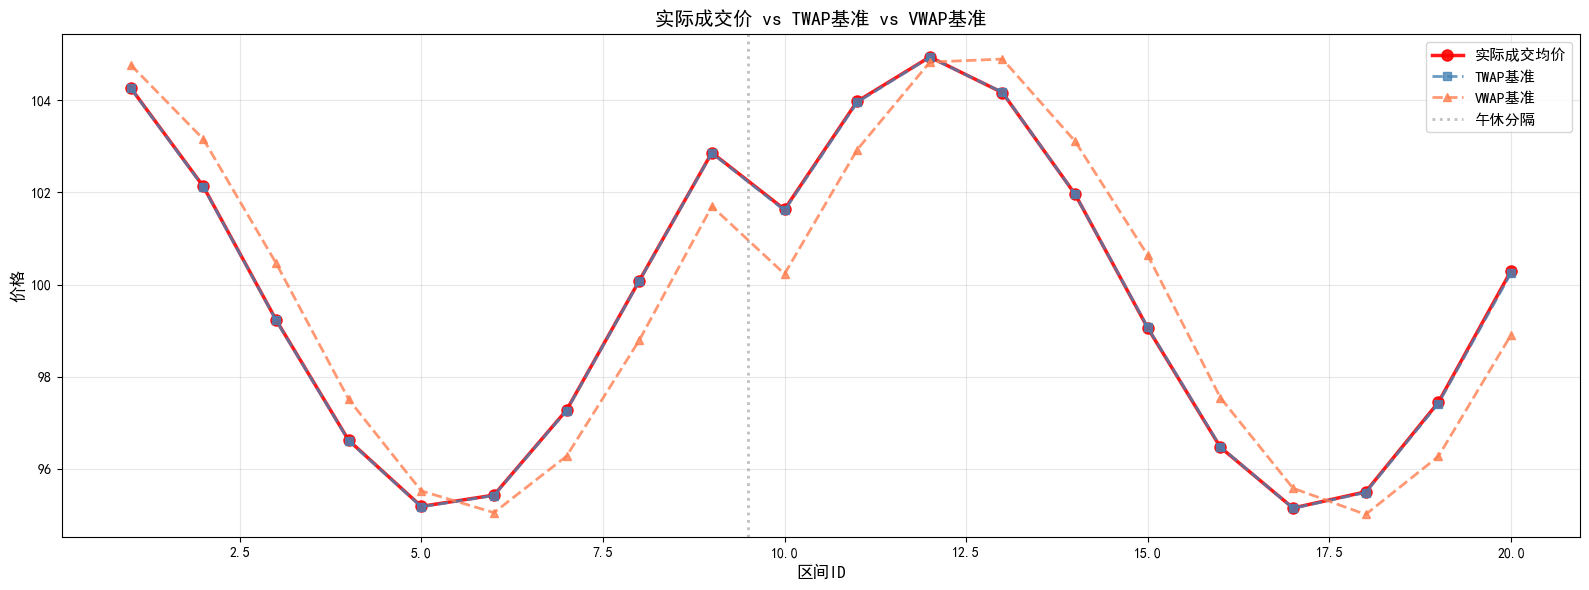

✓ 图表已保存: price_comparison.png


In [7]:
if MATPLOTLIB_OK:
    plt.figure(figsize=(16, 6))
    
    x = results_summary['interval_id']
    
    plt.plot(x, results_summary['avg_execution_price'], 'o-', 
             linewidth=2.5, markersize=8, label='实际成交均价', color='red', alpha=0.9)
    plt.plot(x, results_summary['twap_benchmark'], 's--', 
             linewidth=2, markersize=6, label='TWAP基准', color='steelblue', alpha=0.8)
    plt.plot(x, results_summary['vwap_benchmark'], '^--', 
             linewidth=2, markersize=6, label='VWAP基准', color='coral', alpha=0.8)
    
    plt.axvline(x=9.5, color='gray', linestyle=':', linewidth=2, alpha=0.5, label='午休分隔')
    
    plt.xlabel('区间ID', fontsize=12, fontweight='bold')
    plt.ylabel('价格', fontsize=12, fontweight='bold')
    plt.title('实际成交价 vs TWAP基准 vs VWAP基准', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('price_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 图表已保存: price_comparison.png")
else:
    print("跳过绘图（Matplotlib不可用）")


### 5.3 紧急成交分析


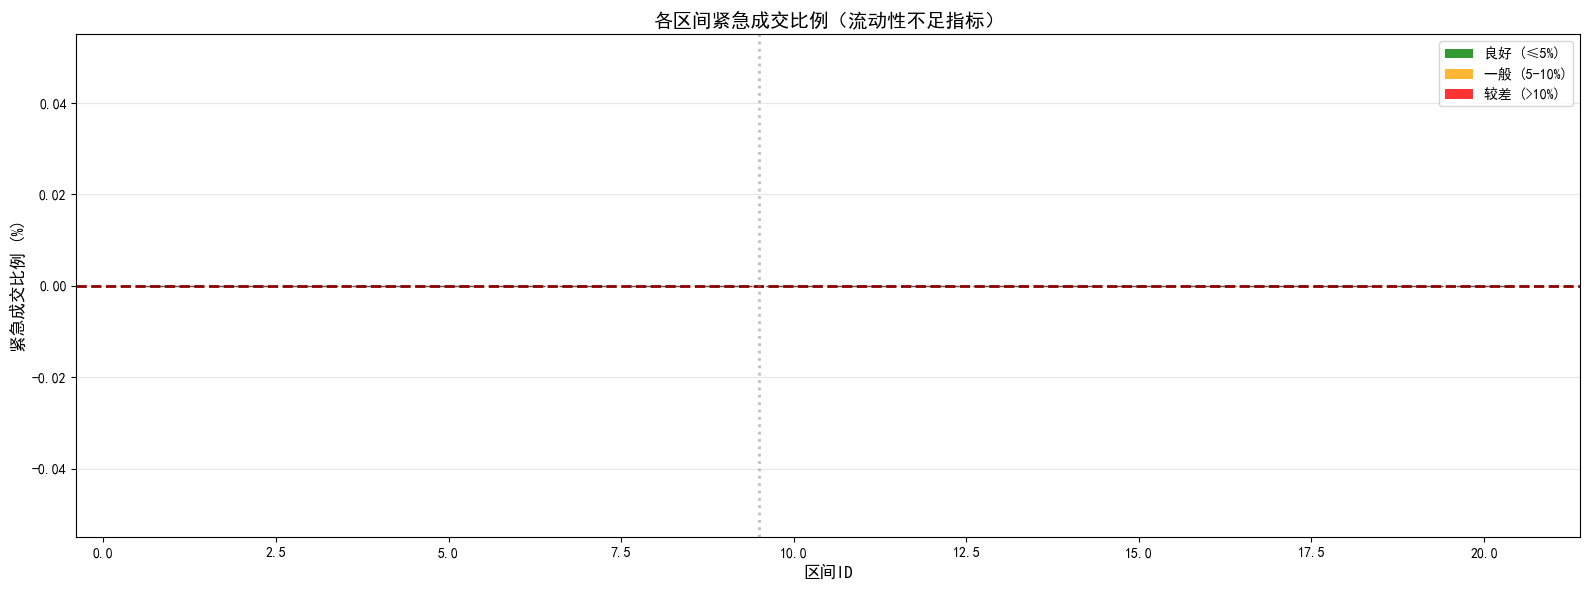

✓ 图表已保存: emergency_trades.png


In [13]:
if MATPLOTLIB_OK:
    plt.figure(figsize=(16, 6))
    
    x = results_summary['interval_id']
    colors = ['red' if pct > 10 else 'orange' if pct > 5 else 'green' 
              for pct in results_summary['emergency_volume_pct']]
    
    plt.bar(x, results_summary['emergency_volume_pct'], alpha=0.8, color=colors, edgecolor='black')
    
    avg_emergency = results_summary['emergency_volume_pct'].mean()
    plt.axhline(y=avg_emergency, color='darkred', linestyle='--', 
                linewidth=2, label=f'平均紧急成交: {avg_emergency:.2f}%')
    plt.axvline(x=9.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
    
    plt.xlabel('区间ID', fontsize=12, fontweight='bold')
    plt.ylabel('紧急成交比例 (%)', fontsize=12, fontweight='bold')
    plt.title('各区间紧急成交比例（流动性不足指标）', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(axis='y', alpha=0.3)
    
    # 添加颜色说明
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.8, label='良好 (≤5%)'),
        Patch(facecolor='orange', alpha=0.8, label='一般 (5-10%)'),
        Patch(facecolor='red', alpha=0.8, label='较差 (>10%)')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('emergency_trades.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 图表已保存: emergency_trades.png")
else:
    print("跳过绘图（Matplotlib不可用）")


### 5.4 哪个基准更优？


ValueError: 'explode' must be of length 'x', not 2

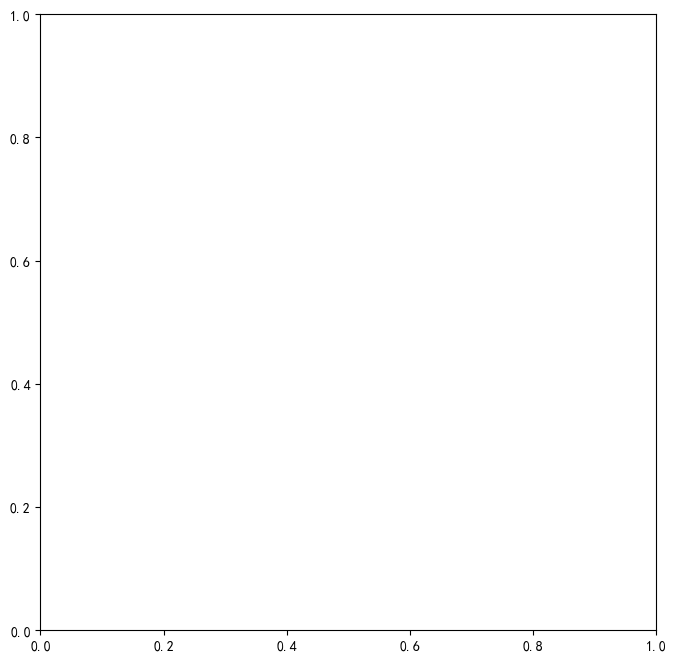

In [15]:
if MATPLOTLIB_OK:
    # 计算哪个基准更优
    results_summary['better'] = results_summary.apply(
        lambda row: 'VWAP' if abs(row['slippage_vs_vwap_bps']) < abs(row['slippage_vs_twap_bps']) else 'TWAP',
        axis=1
    )
    
    # 图1: 饼图 - 哪个基准更优
    plt.figure(figsize=(8, 8))
    winner_counts = results_summary['better'].value_counts()
    colors_pie = ['coral', 'steelblue']
    explode = (0.05, 0.05)
    
    plt.pie(winner_counts.values, labels=winner_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors_pie, explode=explode, shadow=True,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
    plt.title('各区间基准表现优劣对比\n(基于绝对滑点)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('benchmark_comparison_pie.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 图2: 柱状图 - 每个区间的最优基准
    plt.figure(figsize=(16, 6))
    x = results_summary['interval_id']
    colors_bar = ['coral' if b == 'VWAP' else 'steelblue' for b in results_summary['better']]
    
    plt.bar(x, [1]*len(x), alpha=0.8, color=colors_bar, edgecolor='black')
    plt.axvline(x=9.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
    plt.xlabel('区间ID', fontsize=12, fontweight='bold')
    plt.ylabel('基准类型', fontsize=12, fontweight='bold')
    plt.title('各区间最优基准分布', fontsize=14, fontweight='bold')
    plt.yticks([])
    plt.grid(axis='x', alpha=0.3)
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='coral', alpha=0.8, label='VWAP更优'),
        Patch(facecolor='steelblue', alpha=0.8, label='TWAP更优')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('benchmark_comparison_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 图表已保存: benchmark_comparison_pie.png")
    print("✓ 图表已保存: benchmark_comparison_bar.png")
    
    # 统计结果
    print(f"\n基准优劣统计:")
    print(f"  - VWAP更优: {(results_summary['better']=='VWAP').sum()} 个区间")
    print(f"  - TWAP更优: {(results_summary['better']=='TWAP').sum()} 个区间")
else:
    print("跳过绘图（Matplotlib不可用）")


### 5.5 完成率分析


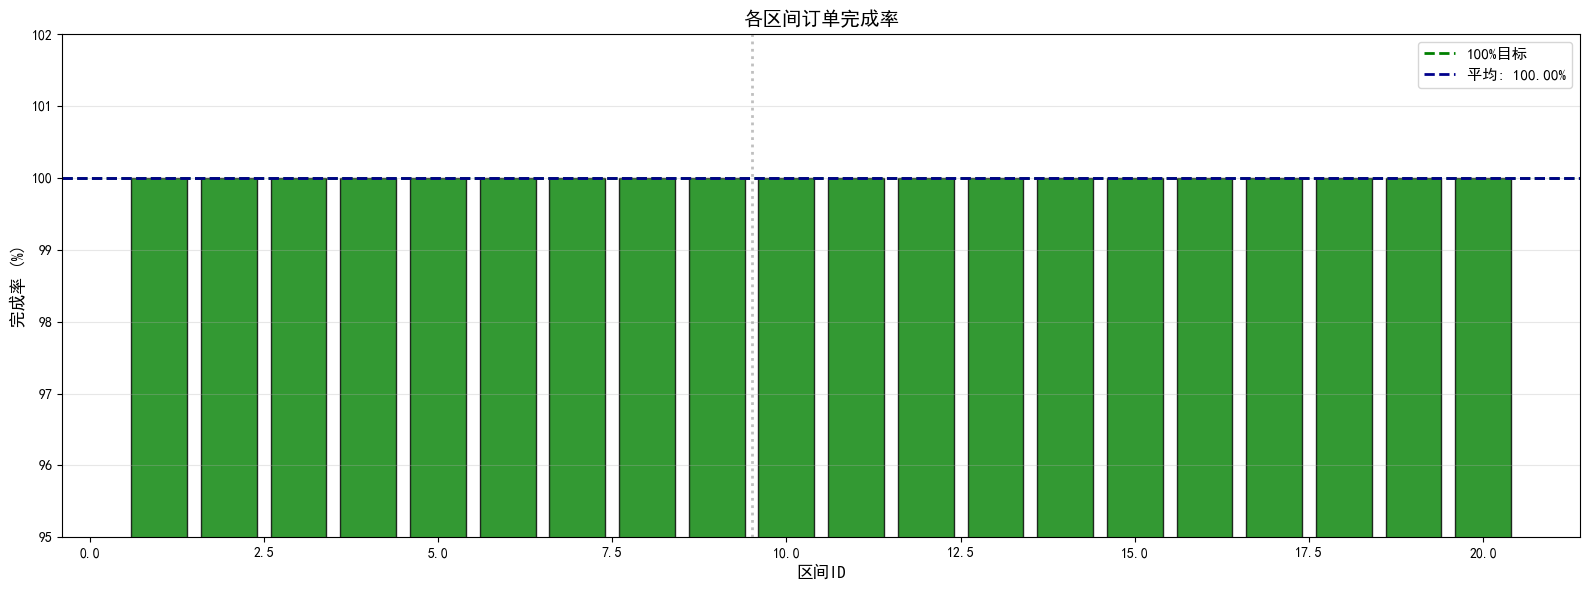

✓ 图表已保存: completion_rate.png


In [11]:
if MATPLOTLIB_OK:
    plt.figure(figsize=(16, 6))
    
    x = results_summary['interval_id']
    completion_pct = results_summary['completion_rate'] * 100
    
    # 根据完成率着色
    colors = ['green' if pct >= 99.5 else 'orange' if pct >= 98 else 'red' 
              for pct in completion_pct]
    
    plt.bar(x, completion_pct, alpha=0.8, color=colors, edgecolor='black')
    plt.axhline(y=100, color='green', linestyle='--', linewidth=2, label='100%目标')
    plt.axhline(y=completion_pct.mean(), color='darkblue', linestyle='--', 
                linewidth=2, label=f'平均: {completion_pct.mean():.2f}%')
    plt.axvline(x=9.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
    
    plt.xlabel('区间ID', fontsize=12, fontweight='bold')
    plt.ylabel('完成率 (%)', fontsize=12, fontweight='bold')
    plt.title('各区间订单完成率', fontsize=14, fontweight='bold')
    plt.ylim([95, 102])
    plt.legend(fontsize=11)
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('completion_rate.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 图表已保存: completion_rate.png")
else:
    print("跳过绘图（Matplotlib不可用）")


## 6. 总结报告


In [12]:
print("="*100)
print("TWAP交易模拟 - 最终总结报告")
print("="*100)

print("\n📊 一、基本指标")
print(f"{'='*80}")
print(f"  模拟区间数: {len(results_summary)}")
print(f"  总目标交易量: {results_summary['target_volume'].sum():,.0f} 股")
print(f"  总实际成交量: {results_summary['executed_volume'].sum():,.0f} 股")
print(f"  整体完成率: {(results_summary['executed_volume'].sum() / results_summary['target_volume'].sum() * 100):.3f}%")

print("\n📈 二、滑点分析")
print(f"{'='*80}")
print(f"\n  相对TWAP基准:")
print(f"    - 平均滑点: {results_summary['slippage_vs_twap_bps'].mean():.3f} bp")
print(f"    - 滑点标准差: {results_summary['slippage_vs_twap_bps'].std():.3f} bp")
print(f"    - 滑点范围: [{results_summary['slippage_vs_twap_bps'].min():.3f}, {results_summary['slippage_vs_twap_bps'].max():.3f}] bp")
print(f"    - 平均绝对滑点: {results_summary['slippage_vs_twap_bps'].abs().mean():.3f} bp")

print(f"\n  相对VWAP基准:")
print(f"    - 平均滑点: {results_summary['slippage_vs_vwap_bps'].mean():.3f} bp")
print(f"    - 滑点标准差: {results_summary['slippage_vs_vwap_bps'].std():.3f} bp")
print(f"    - 滑点范围: [{results_summary['slippage_vs_vwap_bps'].min():.3f}, {results_summary['slippage_vs_vwap_bps'].max():.3f}] bp")
print(f"    - 平均绝对滑点: {results_summary['slippage_vs_vwap_bps'].abs().mean():.3f} bp")

print("\n💰 三、成本估算")
print(f"{'='*80}")
avg_exec_price = (results_summary['avg_execution_price'] * results_summary['executed_volume']).sum() / results_summary['executed_volume'].sum()
avg_twap = (results_summary['twap_benchmark'] * results_summary['target_volume']).sum() / results_summary['target_volume'].sum()
avg_vwap = (results_summary['vwap_benchmark'] * results_summary['target_volume']).sum() / results_summary['target_volume'].sum()

total_cost = results_summary['executed_volume'].sum() * avg_exec_price
twap_cost = results_summary['target_volume'].sum() * avg_twap
vwap_cost = results_summary['target_volume'].sum() * avg_vwap

print(f"  实际成交均价: {avg_exec_price:.4f} 元")
print(f"  TWAP基准均价: {avg_twap:.4f} 元")
print(f"  VWAP基准均价: {avg_vwap:.4f} 元")
print(f"\n  总实际成本: {total_cost:,.2f} 元")
print(f"  TWAP基准成本: {twap_cost:,.2f} 元")
print(f"  VWAP基准成本: {vwap_cost:,.2f} 元")
print(f"\n  相对TWAP额外成本: {total_cost - twap_cost:,.2f} 元 ({((total_cost - twap_cost) / twap_cost * 10000):.2f} bp)")
print(f"  相对VWAP额外成本: {total_cost - vwap_cost:,.2f} 元 ({((total_cost - vwap_cost) / vwap_cost * 10000):.2f} bp)")

print("\n⚡ 四、流动性与紧急成交")
print(f"{'='*80}")
total_emergency = (results_summary['emergency_volume_pct'] * results_summary['target_volume']).sum()
total_target = results_summary['target_volume'].sum()
print(f"  总紧急成交量: {total_emergency:,.0f} 股")
print(f"  紧急成交比例: {(total_emergency / total_target * 100):.2f}%")
print(f"  有紧急成交的区间: {(results_summary['emergency_volume_pct'] > 0).sum()} 个")
print(f"  紧急成交额外成本: 5.00 bp (配置参数)")

emergency_intervals = results_summary[results_summary['emergency_volume_pct'] > 0]
if len(emergency_intervals) > 0:
    print(f"\n  紧急成交最严重的3个区间:")
    top3 = emergency_intervals.nlargest(3, 'emergency_volume_pct')
    for _, row in top3.iterrows():
        print(f"    - 区间 {int(row['interval_id'])}: {row['emergency_volume_pct']:.2f}% ({row['session']})")

print("\n🎯 五、基准选择建议")
print(f"{'='*80}")
abs_twap_avg = results_summary['slippage_vs_twap_bps'].abs().mean()
abs_vwap_avg = results_summary['slippage_vs_vwap_bps'].abs().mean()
vwap_better_count = (results_summary['better'] == 'VWAP').sum()
twap_better_count = (results_summary['better'] == 'TWAP').sum()

print(f"  TWAP基准表现:")
print(f"    - 平均绝对偏差: {abs_twap_avg:.3f} bp")
print(f"    - 表现更优区间数: {twap_better_count}")
print(f"\n  VWAP基准表现:")
print(f"    - 平均绝对偏差: {abs_vwap_avg:.3f} bp")
print(f"    - 表现更优区间数: {vwap_better_count}")

if abs_vwap_avg < abs_twap_avg:
    diff = abs_twap_avg - abs_vwap_avg
    print(f"\n  ✅ 推荐使用 VWAP 作为业绩基准")
    print(f"     理由: VWAP平均偏差比TWAP低 {diff:.3f} bp ({diff/abs_twap_avg*100:.1f}%)")
    print(f"     在 {vwap_better_count}/{len(results_summary)} 个区间中表现更优")
else:
    diff = abs_vwap_avg - abs_twap_avg
    print(f"\n  ✅ 推荐使用 TWAP 作为业绩基准")
    print(f"     理由: TWAP平均偏差比VWAP低 {diff:.3f} bp ({diff/abs_vwap_avg*100:.1f}%)")
    print(f"     在 {twap_better_count}/{len(results_summary)} 个区间中表现更优")

print("\n📝 六、优化建议")
print(f"{'='*80}")
if total_emergency / total_target > 0.1:
    print("  ⚠️  高紧急成交风险:")
    print("     - 紧急成交比例超过10%，流动性约束较强")
    print("     - 建议: 延长交易时间或减少目标交易量")
    print("     - 建议: 在流动性充足时段增加下单量")
elif total_emergency / total_target > 0.05:
    print("  ⚡ 中等紧急成交风险:")
    print("     - 紧急成交比例在5-10%之间")
    print("     - 建议: 采用动态下单策略，根据流动性调整")
else:
    print("  ✅ 流动性充足:")
    print("     - 紧急成交比例低于5%")
    print("     - 当前策略较为合理")

if abs_twap_avg > 3 or abs_vwap_avg > 3:
    print("\n  💡 滑点优化:")
    print("     - 平均滑点超过3bp，有优化空间")
    print("     - 建议: 考虑更智能的下单时机选择")
    print("     - 建议: 分析市场微观结构，避开高波动时段")

print("\n📁 七、输出文件")
print(f"{'='*80}")
print("  生成的文件:")
print("    - twap_simulation_summary.csv (汇总数据)")
if MATPLOTLIB_OK:
    print("    - twap_vs_vwap_slippage.png (滑点对比图)")
    print("    - price_comparison.png (价格对比图)")
    print("    - emergency_trades.png (紧急成交分析)")
    print("    - benchmark_comparison.png (基准优劣对比)")
    print("    - completion_rate.png (完成率分析)")

print("\n" + "="*100)
print("✅ TWAP交易模拟分析完成！")
print("="*100)


TWAP交易模拟 - 最终总结报告

📊 一、基本指标
  模拟区间数: 20
  总目标交易量: 1,106,999 股
  总实际成交量: 1,106,999 股
  整体完成率: 100.000%

📈 二、滑点分析

  相对TWAP基准:
    - 平均滑点: 1.017 bp
    - 滑点标准差: 1.342 bp
    - 滑点范围: [-1.328, 4.781] bp
    - 平均绝对滑点: 1.331 bp

  相对VWAP基准:
    - 平均滑点: 3.321 bp
    - 滑点标准差: 103.074 bp
    - 滑点范围: [-156.678, 140.365] bp
    - 平均绝对滑点: 92.089 bp

💰 三、成本估算
  实际成交均价: 99.6199 元
  TWAP基准均价: 99.6089 元
  VWAP基准均价: 99.5167 元

  总实际成本: 110,279,120.71 元
  TWAP基准成本: 110,267,039.40 元
  VWAP基准成本: 110,164,934.03 元

  相对TWAP额外成本: 12,081.31 元 (1.10 bp)
  相对VWAP额外成本: 114,186.68 元 (10.37 bp)

⚡ 四、流动性与紧急成交
  总紧急成交量: 0 股
  紧急成交比例: 0.00%
  有紧急成交的区间: 0 个
  紧急成交额外成本: 5.00 bp (配置参数)

🎯 五、基准选择建议
  TWAP基准表现:
    - 平均绝对偏差: 1.331 bp
    - 表现更优区间数: 20

  VWAP基准表现:
    - 平均绝对偏差: 92.089 bp
    - 表现更优区间数: 0

  ✅ 推荐使用 TWAP 作为业绩基准
     理由: TWAP平均偏差比VWAP低 90.758 bp (98.6%)
     在 20/20 个区间中表现更优

📝 六、优化建议
  ✅ 流动性充足:
     - 紧急成交比例低于5%
     - 当前策略较为合理

  💡 滑点优化:
     - 平均滑点超过3bp，有优化空间
     - 建议: 考虑更智能的下单时机选择
     - 建议: 分析市场微观结构，避开